# 🔍 Deepfake Audio Detection from Extracted Features

In [1]:
import pandas as pd
import numpy as np
# import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from catboost import CatBoostClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve

import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42)
tf.random.set_seed(42)

## 📥 Reading and Balancing the Training Data

In [50]:
data_path = r"Combined_extracted_features`.csv"
df = pd.read_csv(data_path)
#rename colunm "label" to "LABEL"
df.rename(columns={'label': 'LABEL'}, inplace=True)
print(df.shape)
df.head()

(106197, 19)


mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -363.10654  122.83561 -24.335815  38.338074 -11.006363 -15.065474   
1 -309.21414  120.18135   2.568659  27.876087 -30.114860  13.452702   
2 -397.75262  120.76227 -27.203487  12.296147 -16.766897 -15.709454   
3 -352.02017  137.97342 -28.927328   6.866470 -26.580090 -21.744350   
4 -360.59710  130.81133 -63.693370   4.063354 -30.786812 -20.419847   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10   mfcc_11   mfcc_12    mfcc_13  \
0 -12.783424   3.243497  -6.757111  -1.883177 -1.991337  2.065742  -0.079332   
1 -26.202267  -8.726685 -17.650360  -2.598894 -4.791269  0.555805  -8.908714   
2 -25.128902 -10.521544 -11.317371 -18.418804 -4.874923 -0.053296 -11.061878   
3 -12.041909 -21.091500 -17.128035  -6.971758 -4.749669  6.657670 -12.182097   
4 -17.148111 -36.472107  -6.728297  -5.025222 -0.052140  1.442311  -6.009858   

   spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0        1354.302742         1292.893007       2520.019531   
1        1512.854526         1328.947240       2590.820312   
2        1301.889522         1310.361310       2763.427734   
3         973.442370         1009.648669       1590.576172   
4        1323.583306         1138.173242       2442.626953   

   zero_crossing_rate       rms LABEL  
0            0.093155  0.021351  fake  
1            0.115509  0.028794  fake  
2            0.099152  0.030124  fake  
3            0.070969  0.052067  fake  
4            0.104568  0.030822  fake

In [51]:
df.columns

Index(['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff',
       'zero_crossing_rate', 'rms', 'LABEL'],
      dtype='object')

In [25]:
x=df.drop(columns=['LABEL'])
y=df['LABEL']
x,y,x_visualization,y_visualization = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)
df_v["LABEL"]=y_visualization

In [44]:
# storing df_v to csv
df_v.to_csv("df_v.csv", index=False)

### 🔄 Random Sampling to Balance Class Labels

In [4]:
# check unique values in each column
for col in df.columns:
    print(f"{col}: {df[col].unique()} unique values")

mfcc_1: [-363.10654 -309.21414 -397.75262 ... -242.23392 -178.63715 -175.87262] unique values
mfcc_2: [122.83561 120.18135 120.76227 ...  70.47644  79.75935  56.14059] unique values
mfcc_3: [-24.335815    2.5686593 -27.203487  ... -33.627457  -63.88075
 -90.75545  ] unique values
mfcc_4: [ 38.338074  27.876087  12.296147 ...  18.135014 -14.191528 -36.27864 ] unique values
mfcc_5: [-11.006363 -30.11486  -16.766897 ...   2.737453 -30.895079 -47.88423 ] unique values
mfcc_6: [-15.065474  13.452702 -15.709454 ... -24.08289  -14.215492 -23.75618 ] unique values
mfcc_7: [-12.783424 -26.202267 -25.128902 ... -16.304197 -16.221432 -17.313427] unique values
mfcc_8: [  3.2434974  -8.726685  -10.521544  ... -17.485403   -6.522172
  -8.733846 ] unique values
mfcc_9: [ -6.7571106 -17.65036   -11.317371  ... -21.132116  -11.0317745
 -11.329798 ] unique values
mfcc_10: [ -1.8831774  -2.5988936 -18.418804  ...  12.708282    1.1523097
   9.13616  ] unique values
mfcc_11: [ -1.9913365  -4.7912693  -4.87

In [47]:

fake_df = df[df['LABEL'] == 'fake']
real_df = df[df['LABEL'] == 'real']

real_df_reduced = real_df.sample(frac=0.6, random_state=42)
fake_df_reduced = fake_df.sample(frac=0.6, random_state=42)

# Step 3: Combine reduced FAKE with all REAL
balanced_df = pd.concat([fake_df_reduced, real_df_reduced]).sample(frac=1, random_state=42).reset_index(drop=True)
df_v = balanced_df.copy()
df_v.to_csv("df_v.csv", index=False)


In [91]:
df=balanced_df

In [92]:
df.reset_index(drop=True, inplace=True)
df.head()

mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -199.57999  111.518810  14.694408  52.565400 -17.648820  -3.409582   
1 -262.59700   79.852170 -16.344620  20.372808 -20.483482 -24.757320   
2 -360.65625   75.257576 -38.103645   0.622691  -2.275451  -7.645546   
3 -225.20209   56.843506  25.085575  18.208769 -11.768038 -25.932781   
4 -201.28250   66.659256 -24.202766   4.190798 -17.412490 -17.840122   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12  \
0 -10.801493 -15.989175  -4.998503  -4.900899 -14.979682  -1.453024   
1 -11.558075 -10.068544 -10.649803 -19.994783 -11.010053 -10.968180   
2  -4.297485  -6.889914   4.001376   1.843521   1.983411  -2.822924   
3 -17.845219 -10.685858 -18.142002  -3.669662 -15.648576  -9.907747   
4 -25.697350 -16.750349  -0.015841 -18.924337  -8.921679 -14.853580   

     mfcc_13  spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0  -2.905953        1436.430490         1434.389279       2823.486328   
1 -16.469890        1747.478373         1578.797379       3316.162109   
2 -16.259940        1913.382378         1369.608954       3020.507812   
3 -13.597455        2384.820143         1927.398308       4358.886719   
4   3.708776        2317.026194         1524.255475       3753.662109   

   zero_crossing_rate       rms LABEL  
0            0.134888  0.157747  fake  
1            0.122498  0.059970  fake  
2            0.171524  0.035305  fake  
3            0.238937  0.057338  fake  
4            0.230988  0.108247  real

### ✅ Verifying Class Balance in the Dataset

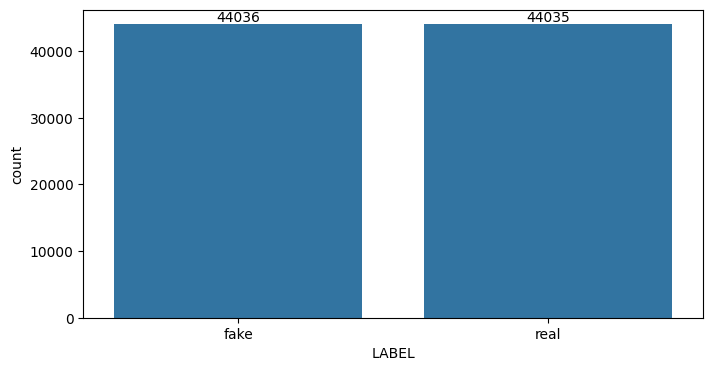

In [93]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='LABEL')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, int(p.get_height()), 
             ha='center', va='bottom')

plt.show()

In [94]:
label_encoder = LabelEncoder()
df['LABEL'] = label_encoder.fit_transform(df['LABEL'])

In [95]:
y = df['LABEL']
X = df.drop('LABEL', axis = 1)

In [18]:
df_v.columns = df_v.columns.str.strip()
df_v.columns = df_v.columns.str.replace('\xa0', '', regex=False)  # Remove non-breaking space


## 📊 Performing Exploratory Data Analysis (EDA)

### 📈 Visualizing Feature Distributions
Creating count plots for each feature to check for visible differences between fake and real audio samples.

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Define your columns (same as before)
mfcc_cols = [f'mfcc_{i}' for i in range(1, 14)]
other_cols = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate', 'rms']

# === 1. MFCCs in Subplots ===
def plot_mfcc_subplots():
    """
    Plot 13 MFCC feature histograms in a grid of subplots with hue='LABEL' using Plotly.
    """
    n_cols = 3
    n_rows = (len(mfcc_cols) + n_cols - 1) // n_cols
    
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=[f'Distribution of {col}' for col in mfcc_cols])
    
    for idx, col in enumerate(mfcc_cols, 1):
        row = (idx - 1) // n_cols + 1
        col_num = (idx - 1) % n_cols + 1
        
        # Add fake data trace
        fig.add_trace(
            go.Histogram(
                x=df_v[df_v['LABEL'] == 'fake'][col],
                name='Fake',
                marker_color='red',
                opacity=0.75,
                nbinsx=50,
                showlegend=True if idx == 1 else False
            ),
            row=row, col=col_num
        )
        
        # Add real data trace
        fig.add_trace(
            go.Histogram(
                x=df_v[df_v['LABEL'] == 'real'][col],
                name='Real',
                marker_color='green',
                opacity=0.75,
                nbinsx=50,
                showlegend=True if idx == 1 else False
            ),
            row=row, col=col_num
        )
    
    fig.update_layout(
        height=n_rows * 300,
        width=n_cols * 400,
        title_text="MFCC Features Distribution",
        title_x=0.5,
        legend_title_text='Label',
        bargap=0.1,
        template='plotly_white'  # similar to whitegrid in seaborn
    )
    
    fig.show()

# === 2. Other Audio Features ===
def plot_other_features():
    """
    Plot individual histograms for other spectral and temporal features using Plotly.
    """
    for col in other_cols:
        fig = px.histogram(
            df_v,
            x=col,
            color='LABEL',
            color_discrete_map={'fake': 'red', 'real': 'green'},
            opacity=0.7,
            nbins=50,
            barmode='overlay',
            title=f'Distribution of {col}'
        )
        
        fig.update_layout(
            width=600,
            height=400,
            legend_title_text='Label',
            legend=dict(
                title_font_size=9,
                font_size=8
            ),
            xaxis_title=col,
            yaxis_title='Count',
            template='plotly_white'
        )
        
        # Update legend labels
        fig.for_each_trace(lambda t: t.update(name='Fake' if t.name == 'fake' else 'Real'))
        
        fig.show()

# === Call plotting functions ===
plot_mfcc_subplots()
plot_other_features()

In [97]:
print(df.shape)
print("_"*50)
print(df.size)
print("_"*50)
print(df.info())

(88071, 19)
__________________________________________________
1673349
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88071 entries, 0 to 88070
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mfcc_1              88071 non-null  float64
 1   mfcc_2              88071 non-null  float64
 2   mfcc_3              88071 non-null  float64
 3   mfcc_4              88071 non-null  float64
 4   mfcc_5              88071 non-null  float64
 5   mfcc_6              88071 non-null  float64
 6   mfcc_7              88071 non-null  float64
 7   mfcc_8              88071 non-null  float64
 8   mfcc_9              88071 non-null  float64
 9   mfcc_10             88071 non-null  float64
 10  mfcc_11             88071 non-null  float64
 11  mfcc_12             88071 non-null  float64
 12  mfcc_13             88071 non-null  float64
 13  spectral_centroid   88071 non

### 🔥 Correlation Heatmap
Identifying correlations between numerical features to understand data relationships.

In [98]:
import seaborn as sn

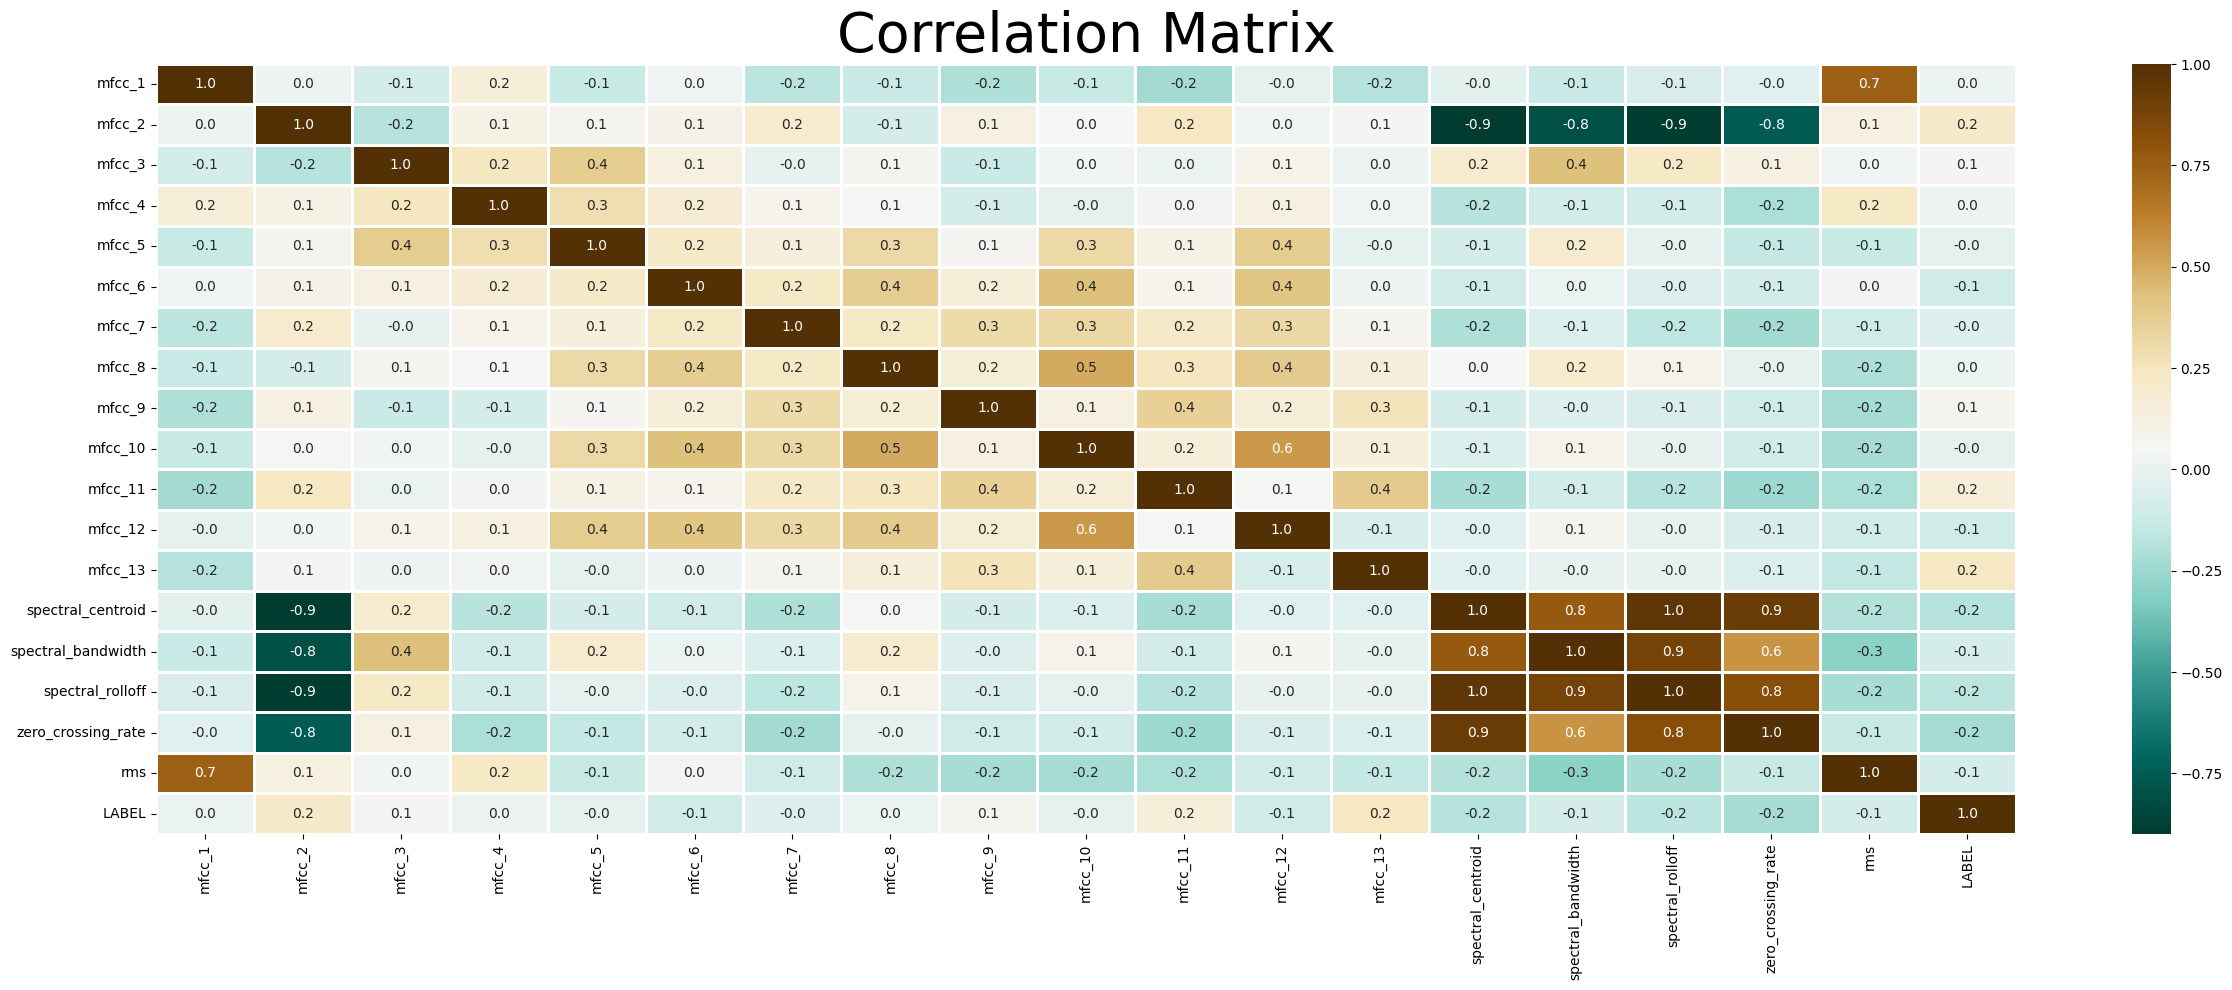

In [99]:
correlation_matrix = df.corr()
plt.figure(figsize=(30, 10))
plt.title('Correlation Matrix',
          fontsize = 40)
dfplot =sn.heatmap(correlation_matrix,cmap="BrBG_r",annot=True,fmt=".1f",linewidth=1)


## 🤖 Model Training and Evaluation

### 📂 Loading Validation Dataset
Importing an external dataset to verify the model’s generalization performance.

In [3]:
var_df=pd.read_csv(r"df_v.csv")
var_df.head()

mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -198.24677  108.698430   0.344206  33.994410  -2.699678  -9.669279   
1 -197.07590  109.814000 -35.974840  19.710450 -23.257309  12.941952   
2 -159.99190  103.038160 -11.353895  66.366670 -20.720089  16.205536   
3 -182.74765   79.233444 -27.785210  40.949080 -13.754372  -0.339193   
4 -304.45862   82.469560 -47.657700 -10.351948 -26.044308  -8.991628   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12  \
0 -10.522922  -6.055335  -5.145186 -16.218851  -4.900630 -14.904575   
1 -28.395374  -9.565921  -5.969711 -19.170536  -8.661194 -12.305864   
2 -38.130250   3.217812 -16.939740  -1.392817 -22.460370  -2.062920   
3 -20.362587 -11.127826 -24.753883 -15.477485 -13.901408 -17.862600   
4  -5.094892   7.153624  -0.400463   6.283394   1.801143   1.458832   

     mfcc_13  spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0  -4.560134        1319.021917         1589.098167       2842.285156   
1  -4.088147        1308.690954         1315.017820       2372.314453   
2 -15.850328        1519.253827         1507.978408       3243.652344   
3   0.902594        1506.355823         1472.100920       2926.025391   
4  -6.315875        1901.021275         1607.961516       3536.621094   

   zero_crossing_rate       rms LABEL  
0            0.061600  0.085198  real  
1            0.093048  0.157655  fake  
2            0.101303  0.124874  real  
3            0.095886  0.152577  fake  
4            0.147186  0.010175  fake

### 🔍 Separating Features from the Validation DataFrame

In [134]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
var_df["label"]=le.fit_transform(var_df['label'])
var_X= var_df.drop('label', axis = 1)
var_X.head()

mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -312.86070  151.44388  -7.688050  33.361040  -1.739147 -13.376539   
1 -332.90500  131.34220   1.639415  49.667000  -0.681332  -7.139419   
2 -318.26110  155.00656 -36.666706  47.664963  -6.104814 -29.603207   
3 -310.53485  140.35892  -3.232129  28.348663  -8.441719  -4.221230   
4 -330.66943  140.13562   5.995147  33.157356 -14.125609   8.244333   

      mfcc_7     mfcc_8     mfcc_9   mfcc_10    mfcc_11   mfcc_12    mfcc_13  \
0 -27.201260 -18.680187 -13.325327  0.216185 -12.955355 -1.382775  -6.615449   
1 -26.505720 -20.673347 -16.370066 -3.149470 -24.022785 -1.012550  -2.237302   
2 -23.137941 -11.026470 -15.576722  4.813222 -14.532869 -1.196303 -10.172891   
3 -35.931730  -5.481759 -20.868530  5.955879 -13.360066  1.462287 -14.631861   
4 -35.392128  -6.132903  -6.306569 -6.395593 -10.224894 -0.117464 -21.218082   

   spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0         865.826030         1055.736536       1593.505859   
1        1114.804254         1301.333966       2329.345703   
2         976.383049         1016.042797       1909.912109   
3        1118.613545         1344.337421       2396.728516   
4         947.290547         1254.757695       1650.878906   

   zero_crossing_rate       rms  
0            0.066101  0.051010  
1            0.070770  0.031981  
2            0.071487  0.035136  
3            0.068451  0.031011  
4            0.054611  0.023302

**For LSTM:** Splits time series into 3D windows (`[samples, timesteps, features]`).

In [ ]:
def prepare_data(X, window_size = 10):
    
    data = []
    
    for i in range(len(X)):
        row = X.iloc[i].values
        row_data = []
        for j in range(len(row) - window_size):
            window = row[j : j + window_size]
            row_data.append(window)
        data.append(row_data)
        
    return np.array(data)
new_X = prepare_data(X, window_size = 5)

In [ ]:

new_X = prepare_data(X, window_size = 5)
var_X_new= prepare_data(var_X, window_size = 5)

### SPLITTING DATA INTO TRAIN TEST AND VALIDATION DATA

In [105]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y.values, test_size=0.2, shuffle = True, stratify = y.values, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state=42)

### DEFINGING AND COMPILING MODEL

In [106]:
model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 13, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,561 (822.50 KB)

 Trainable params: 210,561 (822.50 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
callback = [
    ModelCheckpoint(filepath='model.keras'),
]

### FITTING MODEL

In [108]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data = (X_val, y_val), callbacks = callback)

Epoch 1/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6706 - loss: 0.5980 - val_accuracy: 0.7991 - val_loss: 0.4306
Epoch 2/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8100 - loss: 0.4162 - val_accuracy: 0.8452 - val_loss: 0.3521
Epoch 3/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8485 - loss: 0.3425 - val_accuracy: 0.8675 - val_loss: 0.2993
Epoch 4/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8720 - loss: 0.2953 - val_accuracy: 0.8816 - val_loss: 0.2756
Epoch 5/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8849 - loss: 0.2674 - val_accuracy: 0.8929 - val_loss: 0.2547
Epoch 6/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8977 - loss: 0.2451 - val_accuracy: 0.8984 - val_loss: 0.2526
Epoch 7/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9030 - loss: 0.2293 - val_accuracy: 0.9053 - val_loss: 0.2336
Epoch 8/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9120 - loss: 0.2127 - 

In [109]:
model = load_model('model.keras')

### CHECKING DIFFERENT EVALUATION METRICES ON TEST DATA

In [110]:
%%time
y_pred = np.round(model.predict(X_test).flatten())

551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
CPU times: total: 8.73 s
Wall time: 4.52 s


In [111]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [112]:
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9209196707351689
F1 Score:  0.9202496135569932
Recall:  0.9125695469512888
Precision:  0.9280600461893764


In [113]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      8808
           1       0.93      0.91      0.92      8807

    accuracy                           0.92     17615
   macro avg       0.92      0.92      0.92     17615
weighted avg       0.92      0.92      0.92     17615



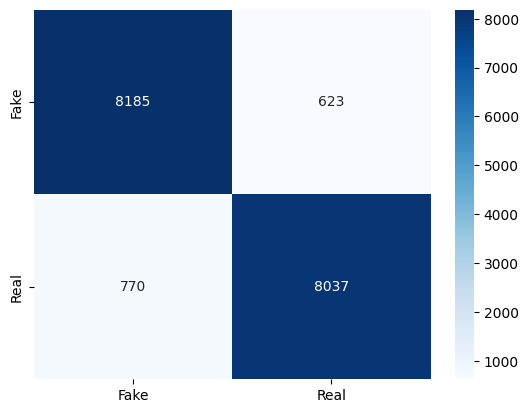

In [114]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='d', cmap='Blues')
ax.xaxis.set_ticklabels(['Fake', 'Real'])
ax.yaxis.set_ticklabels(['Fake', 'Real'])
plt.show()

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

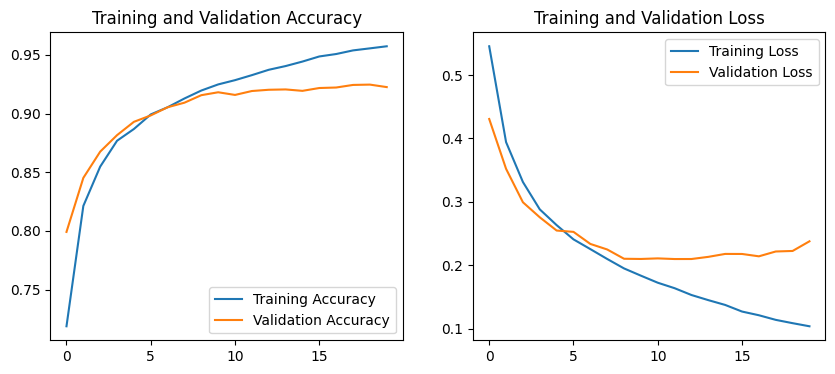

In [116]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
EPOCHS = len(acc)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [171]:
import time
start = time.time()
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 0.0s


In [67]:
%timeit -n 10 -r 3  model.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━

## APPLYING MY MODEL TO THE THE OTHER VERIFICATION DF

In [136]:
var_pred=np.round(model.predict(var_X_new)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [137]:
var_pred.mean()

np.float32(0.85)

In [34]:
acc = accuracy_score(var_df['label'], var_pred)
acc

0.48362711378618517

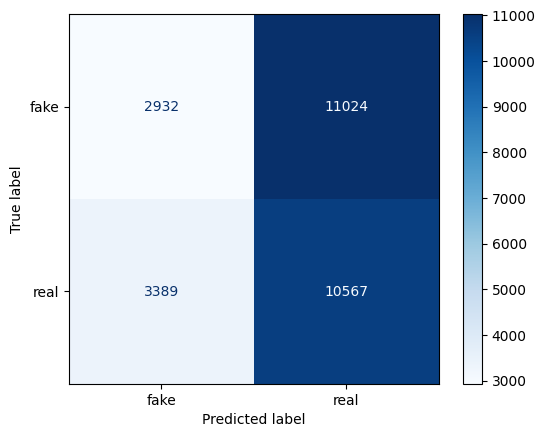

In [35]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(var_df['label'], var_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()